In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from skimage.measure import compare_ssim as ssim
import matplotlib.pyplot as plt
import time
import os
import copy
import h5py
import sys
import torch
from PIL import Image
import gc

sys.path.append('../code')

from python.finetune_commons import show_images, ft_train_model, visualize_model
from python.commons import load_dict_from_hdf5, save_dict_to_hdf5, inc_inference_e2e, full_inference_e2e, adaptive_drilldown, generate_heatmap
from python.vgg16 import VGG16
from python.resnet18 import ResNet18

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
torch.manual_seed(245)
np.random.seed(345)

data_dir = '../data/oct/DRUSEN_NORMAL'

n_labels = 2

In [4]:
transform = transforms.Compose([
        transforms.Resize(224),
        #transforms.CenterCrop(224),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),

        #imagenet
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        #bone
        #transforms.Normalize([0.18805075, 0.18805075, 0.18805075], [0.1892409, 0.1892409, 0.1892409])
        
        #chest
        #transforms.Normalize([0.5709945, 0.5709945, 0.5709945], [0.1767184, 0.1767184, 0.1767184])
        
        #oct
        #transforms.Normalize([0.1930184, 0.1930184, 0.1930184], [0.21612172, 0.21612172, 0.21612172])
    ])
    
    
data_transforms = {'train': transform, 'validation': transform}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=256,
                        shuffle=True, num_workers=4) for x in ['train', 'validation']}

In [5]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['DRUSEN', 'NORMAL']


### VGG16

In [5]:
model_ft = models.vgg16(pretrained=True)
model_ft = model_ft.eval()
for param in model_ft.features.parameters():
    param.requires_grad = False
    
num_ftrs = model_ft.classifier[-1].in_features
temp = list(model_ft.classifier.children())[:-1]
temp.append(nn.Linear(num_ftrs, n_labels))
temp.append(nn.Softmax(dim=1))
model_ft.classifier = nn.Sequential(*temp)

for param in model_ft.classifier[0:-2].parameters():
    param.requires_grad = False

    
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.classifier[-2].parameters(), lr=1e-3)#, weight_decay=1e-8)

### ResNet18

In [16]:
model_ft = models.resnet18(pretrained=True)
model_ft = model_ft.eval()
for param in model_ft.parameters():
    param.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
temp = []
temp.append(nn.Linear(num_ftrs, n_labels))
temp.append(nn.Softmax(dim=1))
model_ft.fc = nn.Sequential(*temp)

for param in model_ft.fc.parameters():
    param.requires_grad = True

    
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=1e-3)#, weight_decay=1e-8)

In [17]:
model_ft = ft_train_model(model_ft, criterion, optimizer_ft, dataloaders, device,
                          dataset_sizes, class_names, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.5628 Acc: 0.7513
validation Loss: 0.5627 Acc: 0.7505
Epoch 1/19
----------
train Loss: 0.5613 Acc: 0.7520
validation Loss: 0.5627 Acc: 0.7505
Epoch 2/19
----------
train Loss: 0.5612 Acc: 0.7520
validation Loss: 0.5626 Acc: 0.7505
Epoch 3/19
----------
train Loss: 0.5531 Acc: 0.7591
validation Loss: 0.4912 Acc: 0.8151
Epoch 4/19
----------
train Loss: 0.4479 Acc: 0.8767
validation Loss: 0.4332 Acc: 0.8904
Epoch 5/19
----------
train Loss: 0.4271 Acc: 0.8949
validation Loss: 0.4252 Acc: 0.8971
Epoch 6/19
----------
train Loss: 0.4210 Acc: 0.8978
validation Loss: 0.4219 Acc: 0.8949
Epoch 7/19
----------
train Loss: 0.4174 Acc: 0.9006
validation Loss: 0.4211 Acc: 0.8930
Epoch 8/19
----------
train Loss: 0.4165 Acc: 0.9000
validation Loss: 0.4165 Acc: 0.9030
Epoch 9/19
----------
train Loss: 0.4136 Acc: 0.9020
validation Loss: 0.4152 Acc: 0.9017
Epoch 10/19
----------
train Loss: 0.4124 Acc: 0.9030
validation Loss: 0.4143 Acc: 0.9010
Epoch 11/19
--------

In [18]:
# final_layer = {}
# final_layer['fc8_W:0'] = model_ft.classifier[-2].weight.data.cpu().numpy()
# final_layer['fc8_b:0'] = model_ft.classifier[-2].bias.data.cpu().numpy()
# save_dict_to_hdf5(final_layer, './oct_drusen_vgg16_ptch.h5')

# temp_weights_data = load_dict_from_hdf5('oct_drusen_vgg16_ptch.h5', gpu=True)
# model_ft.classifier[-2].weight.data = temp_weights_data['fc8_W:0']
# model_ft.classifier[-2].bias.data = temp_weights_data['fc8_b:0']

# final_layer = {}
# final_layer['fc:w'] = model_ft.fc[0].weight.data.cpu().numpy()
# final_layer['fc:b'] = model_ft.fc[0].bias.data.cpu().numpy()
# save_dict_to_hdf5(final_layer, './oct_drusen_resnet18_ptch.h5')

temp_weights_data = load_dict_from_hdf5('oct_drusen_resnet18_ptch.h5', gpu=True)
model_ft.fc[0].weight.data = temp_weights_data['fc:w']
model_ft.fc[0].bias.data = temp_weights_data['fc:b']

In [8]:
#file_path = '../data/oct/validation/CNV/CNV-375851-1.jpeg'
#file_path = '../data/oct/validation/CNV/CNV-5446025-7.jpeg'
file_path = '../data/oct/DRUSEN_NORMAL/validation/DRUSEN/DRUSEN-5333808-1.jpeg'

In [9]:
print(model_ft(data_transforms['validation'](Image.open(file_path).convert('RGB')).unsqueeze(0).cuda()))

tensor([[ 0.2130,  0.7870]], device='cuda:0')


In [10]:
# weights_data = load_dict_from_hdf5('../code/python/vgg16_weights_ptch.h5', gpu=True)
# weights_data['fc8_W:0'] = model_ft.classifier[-2].weight.data
# weights_data['fc8_b:0'] = model_ft.classifier[-2].bias.data

weights_data = load_dict_from_hdf5('../code/python/resnet18_weights_ptch.h5', gpu=True)
weights_data['fc:w'] = model_ft.fc[0].weight.data
weights_data['fc:b'] = model_ft.fc[0].bias.data

In [11]:
patch_size = 16
stride = 4
logit_index= 1

In [12]:
gc.collect()
torch.cuda.empty_cache()

In [13]:
# prev_time = time.time()
# x = full_inference_e2e(VGG16, file_path, patch_size, stride, logit_index, batch_size=128, n_labels=2,
#                        weights_data=weights_data, loader=data_transforms['validation'])
# print('Runtime: ' + str((time.time()-prev_time)) + " s")
# orig_hm = generate_heatmap(file_path, x, show=True, label="")

In [14]:
gc.collect()
torch.cuda.empty_cache()

Runtime: 1.37454485893 s


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


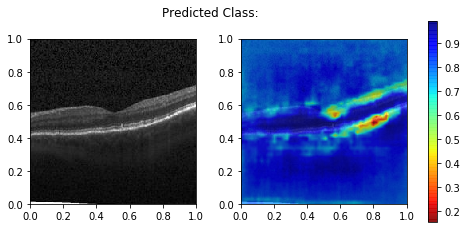

Runtime: 0.775257825851 s


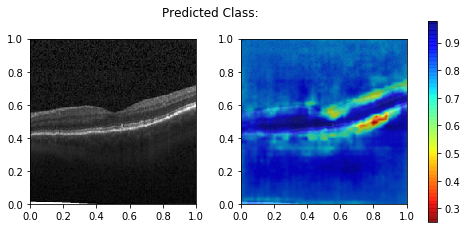

Runtime: 0.653050899506 s


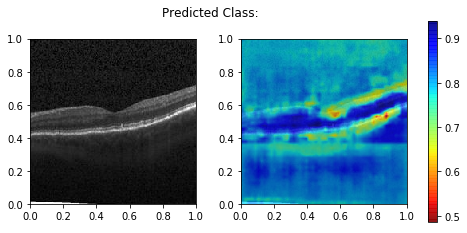

Runtime: 0.519269943237 s


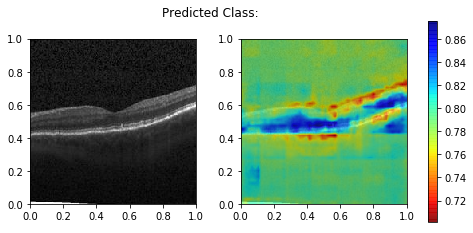

In [15]:
for b in [1., 0.5, 0.4, 0.3]:
    prev_time = time.time()
    x = inc_inference_e2e(ResNet18, file_path, patch_size, stride, logit_index, batch_size=128, beta=b,
                          x0=0, y0=0, image_size=224,
                          x_size=224, y_size=224, gpu=True, n_labels=2,
                          weights_data=weights_data, loader=data_transforms['validation'], c=0.0)

    print('Runtime: ' + str((time.time()-prev_time)) + " s")
    hm_th = generate_heatmap(file_path, x, show=True, label="")

In [32]:
gc.collect()
torch.cuda.empty_cache()

Runtime: 2.11602115631 s


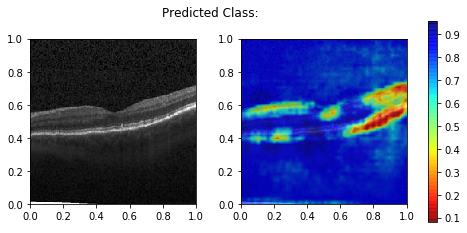

In [33]:
prev_time = time.time()
x = inc_inference_e2e(VGG16, file_path, patch_size, stride, logit_index, batch_size=256,
                      beta=0.4, n_labels=2, weights_data=weights_data, loader=data_transforms['validation'])
print('Runtime: ' + str((time.time()-prev_time)) + " s")
hm_th = generate_heatmap(file_path, x, show=True, label="")

In [34]:
print("SSIM Index: " + str(ssim(orig_hm, hm_th, data_range=255, multichannel=True)))

SSIM Index: 0.988352434964462


In [35]:
gc.collect()
torch.cuda.empty_cache()

Runtime: 2.70817995071 s


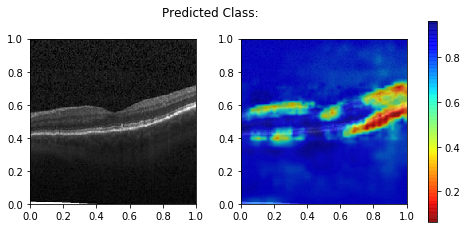

In [36]:
prev_time = time.time()
x = adaptive_drilldown(VGG16, file_path, patch_size, stride, logit_index,
                   batch_size=256, image_size=224, beta=1.0, percentile=10, gpu=True, n_labels=2, weights_data=weights_data)
print('Runtime: ' + str((time.time()-prev_time)) + " s")
hm_adaptive = generate_heatmap(file_path, x, show=True, label="")

In [37]:
print("SSIM Index: " + str(ssim(orig_hm, hm_adaptive, data_range=255, multichannel=True)))

SSIM Index: 0.9333015453090319
